## Inspect, Crop, and Export UAS Imagery

In [36]:
from PIL import Image
import os
import argparse
import numpy as np
import json
import csv
import rasterio
import matplotlib
import folium
from pyproj import Proj, transform


%matplotlib inline


Image.MAX_IMAGE_PIXELS = 100000000000
data_dir = '../data/'

In [37]:
# ingest the image
infile = data_dir + "mosaics/SteepleJason_03Nov2019_DuetT_RGB_transparent_mosaic_group1.tif"

img_dir = '..' + infile.split(".")[2]
prj_name = img_dir.split("/")[-1]

In [38]:
infile

'../data/mosaics/SteepleJason_03Nov2019_DuetT_RGB_transparent_mosaic_group1.tif'

In [39]:
img_dir

'../data/mosaics/SteepleJason_03Nov2019_DuetT_RGB_transparent_mosaic_group1'

In [40]:
dataset = rasterio.open(infile)

In [41]:
# what is the name of this image
img_name = dataset.name
print('Image filename: {n}\n'.format(n=img_name))

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.descriptions
metadata = dataset.meta

print('Raster description: {desc}\n'.format(desc=desc))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj, '\n')

# What is the raster's "geo-transform"
gt = dataset.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

Image filename: ../data/mosaics/SteepleJason_03Nov2019_DuetT_RGB_transparent_mosaic_group1.tif

Number of bands in image: 4

Image size is: 22101 rows x 27147 columns

Raster description: (None, None, None, None)

Raster driver: GTiff

Image projection:
EPSG:32720 

Image geo-transform:
| 0.03, 0.00, 623909.17|
| 0.00,-0.03, 4344864.53|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 27147, 'height': 22101, 'count': 4, 'crs': CRS.from_epsg(32720), 'transform': Affine(0.02749, 0.0, 623909.17457,
       0.0, -0.02749, 4344864.53301)}




### plot the image

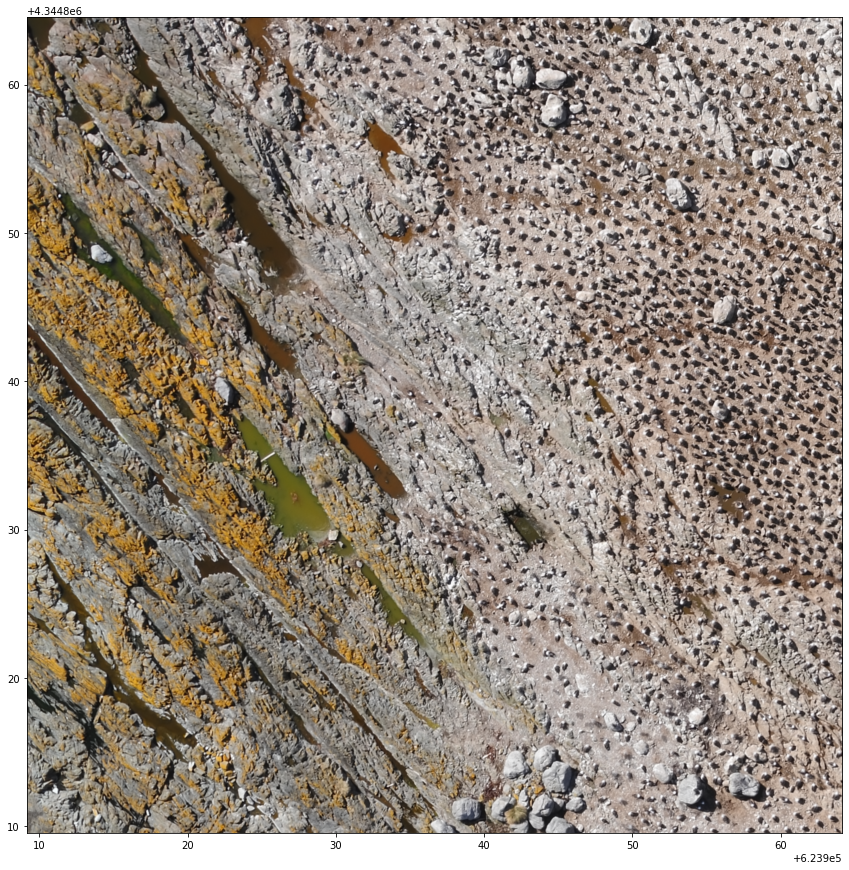

In [42]:
from rasterio.plot import show
from rasterio.windows import Window
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))

show(dataset.read((1,2,3), window=Window(5000, 5000, 2000, 2000)), transform=dataset.transform, ax=ax)
plt.show()

### inspect image bands

In [44]:
from rasterio.windows import Window
with rasterio.open(data_dir + "mosaics/SteepleJason_03Nov2019_DuetT_RGB_transparent_mosaic_group1.tif") as src:
    w = src.read(1, window=Window(0, 0, 512, 256))

KeyboardInterrupt: 

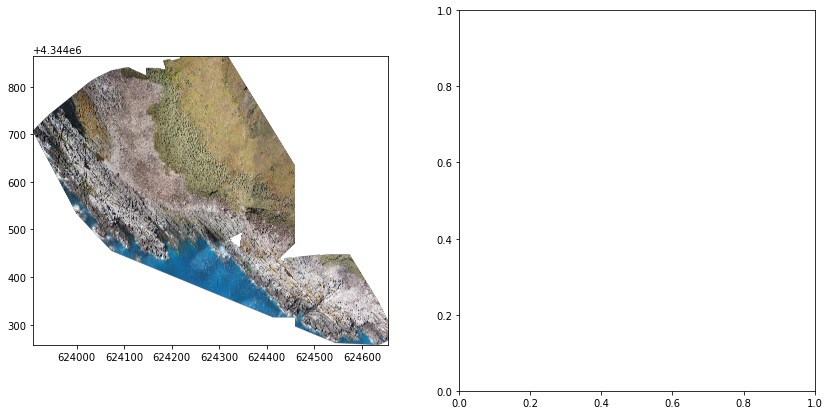

In [45]:
# plot the image with a histogram of band intensities

from rasterio.plot import show_hist

fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
#show(dataset, ax=axrgb)
show(dataset.read(), transform=dataset.transform, ax=axrgb)
show_hist(dataset, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

## Visualize on the Map

In [46]:
dataset.crs

CRS.from_epsg(32720)

In [47]:
# Project all longitudes, latitudes
utm_tl = dataset.transform * (0, 0)
utm_br = dataset.transform * (dataset.width, dataset.height)
utm_center = dataset.transform * (dataset.width // 2, dataset.height // 2)

positions = dataset.transform * (0, 0), dataset.transform * (dataset.width, 0), dataset.transform * (dataset.width, dataset.height), dataset.transform * (0, dataset.height),

#longs, lats = transform(p1, p2, np.array(positions)[:,0],np.array(positions)[:,1])

p1 = Proj(dataset.crs)
p2 = Proj(proj='latlong',datum='WGS84')
tl_long, tl_lat = transform(p1, p2, utm_tl[0], utm_tl[1])
br_long, br_lat = transform(p1, p2, utm_br[0], utm_br[1])
center_long, center_lat = transform(p1, p2, utm_center[0], utm_center[1])
longs, lats = transform(p1, p2, np.array(positions)[:,0],np.array(positions)[:,1])

In [48]:
points = list(zip(lats, longs))

In [49]:
tl_long,tl_lat

(-61.23278221160663, -51.034392497717036)

In [50]:
m = folium.Map(location=[center_lat, center_long])

tooltip="Raster"
#folium.Marker([tl_lat, tl_long], popup='<i>Raster Top Left</i>', tooltip=tooltip).add_to(m)
#folium.Marker([br_lat, br_long], popup='<i>Raster Bottom right</i>', tooltip=tooltip).add_to(m)
#folium.Marker([center_lat, center_long], popup='<i>Raster Center</i>', tooltip=tooltip).add_to(m)

folium.Polygon(points, 
               tooltip=tooltip, 
               popup='Laurelhurst Park',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc').add_to(m)

#folium.PolyLine(points, color="red", weight=100, opacity=1).add_to(m)

m

## Crop the Image into Tiles

In [51]:
tile_height = tile_width = 1000
overlap = 80
stride = tile_height - overlap
start_num=0

def crop(infile, tile_height, tile_width, stride, img_dict, prj_name):
    im = Image.open(infile) 
    img_width, img_height = im.size
    print(im.size)
    print(img_width * img_height / (tile_height - stride) / (tile_width - stride))
    count = 0
    for r in range(0, img_height-tile_height+1, stride):
        for c in range(0, img_width-tile_width+1, stride):
            #tile = im[r:r+100, c:c+100]
            box = (c, r, c+tile_width, r+tile_height)
            top_pixel = [c,r]
            img_dict[prj_name + "---" + str(count) + ".png"] = top_pixel
            count += 1
            yield im.crop(box)

### split the image up into `height` x `width` patches

In [52]:
img = Image

In [53]:
! echo $PWD

/host/steeplejason/data_mgmt


In [54]:
img_dict = {}

# create the dir if it doesn't already exist
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# break it up into crops
for k, piece in enumerate(crop(infile, tile_height, tile_width, stride, img_dict, prj_name), start_num):
    img=Image.new('RGB', (tile_height, tile_width), (255, 255, 255))
    print(img.size)
    print(piece.size)
    img.paste(piece)
    image_name = prj_name + "---%s.png" % k
    path=os.path.join(img_dir, image_name)
    img.save(path)

UnidentifiedImageError: cannot identify image file '../data/mosaics/SteepleJason_03Nov2019_DuetT_RGB_transparent_mosaic_group1.tif'

### add a .json file with all image names and geospatial metadata

In [37]:
full_dict = {"image_name" : infile,
            "image_locations" : img_dict,
             "crs" : str(dataset.crs)
            }

with open(img_dir + '/data.json', 'w') as fp:
    json.dump(full_dict, fp)